In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2019-02-24 
Git hash: f9a755c9ef13ad8d0af3d21d28cffe6e5451402f


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [5]:
rnaseq = (
    pd.read_parquet('../output/metadata-wf/select_library_strategy.parquet')
    .rename(columns={'Fear_et_al_library_strategy': 'strategy'})
    .strategy
    .pipe(lambda x: x[x == 'RNA-Seq'])
    .index.unique().tolist()
)

In [6]:
df = (
    pd.DataFrame(list(
        ncbi.aggregate([
            {
                '$match': {
                    '_id': {'$in': rnaseq}
                }
            },
            {'$unwind': {'path': '$runs'}},
            {
                '$project': {
                    '_id': False,
                    'srx': '$srx',
                    'srr': '$runs.srr',
                    'date': '$runs.load_date',
                }
            },
        ])
    ))
    .set_index(['srx', 'srr'])
    .assign(date=lambda df: pd.to_datetime(df.date))
    .sort_values('date')
    .assign(year=lambda df: df.date.dt.year)
    .dropna()
    .assign(year=lambda df: df.year.astype(int))
)

In [7]:
libsize = (
    store.select('prealn/workflow/fastq', where='srx == rnaseq')
    .assign(libsize = lambda df: df[['libsize_R1', 'libsize_R2']].max(axis=1))
    .assign(readlen = lambda df: df[['avgLen_R1', 'avgLen_R2']].max(axis=1))
    .loc[:, ['libsize', 'readlen']]
)

aln = store.select('aln/workflow/hisat2', where='srx == rnaseq')['per_alignment']

df = df.join(libsize).join(aln)

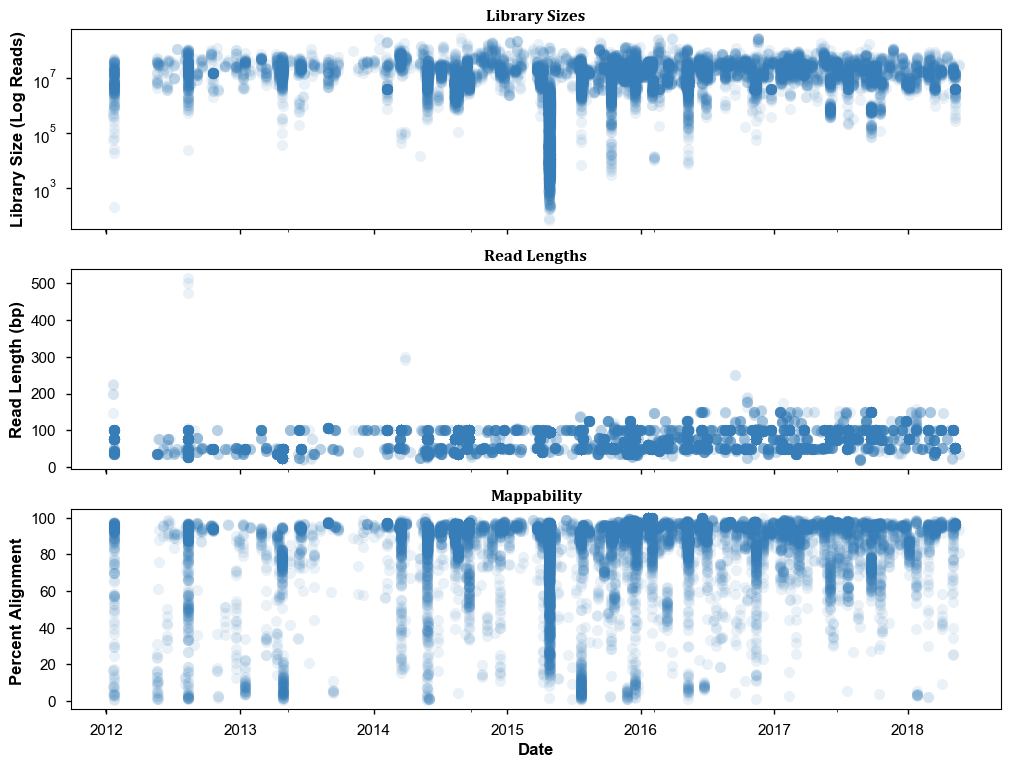

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

df.plot('date', 'libsize', marker='o', ls='None', ax=ax1, markersize=8, alpha=0.1, rasterized=True)
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Library Size (Log Reads)', fontweight='bold')
ax1.set_title('Library Sizes', fontweight='bold', family='Cambria')
ax1.set_yscale('log')
ax1.legend_.remove()

df.plot('date', 'readlen', marker='o', ls='None', ax=ax2, markersize=8, alpha=0.1, rasterized=True)
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('Read Length (bp)', fontweight='bold')
ax2.set_title('Read Lengths', fontweight='bold', family='Cambria')
ax2.legend_.remove()

df.plot('date', 'per_alignment', marker='o', ls='None', ax=ax3, markersize=8, alpha=0.1, rasterized=True)
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('Percent Alignment ', fontweight='bold')
ax3.set_title('Mappability', fontweight='bold', family='Cambria')
ax3.legend_.remove()

fig.autofmt_xdate(rotation=0, ha='center')
fig.savefig('../output/notebook/2019-02-24_rnaseq_quality.svg', bbox_inches='tight')